In [13]:
from pymongo import MongoClient
import numpy as np
from my_tools import get_bill_data, process_corpus, write_json_file, write_jsonl_file
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score

from sklearn.externals import joblib


In [2]:
data = get_bill_data()

------------------
------------------
Data includes bills, joints resolutions, and laws with text from the 110th Congress (2007) to present
Make changes in my_tools.get_bill_data to modify the data set.
------------------


In [3]:
X, y = process_corpus(data, 'body')

------------------
Creating corpus...
------------------
Tokenizing...
------------------
Stripping out stop words, punctuation, and numbers...
------------------
Lemmatizing...
------------------
NLP preprocessing complete ...


In [11]:
# output corpus to eliminate multiple preprocessing events.
outfile_path = '../data/nlp/corpus_with_labels.jsonl'
#reset file
write_jsonl_file([''], outfile_path)
for i in range(len(X)):
    output = {str(i): {'document': X[i], 'label': str(y[i])}}
    write_json_file(output, outfile_path)

In [12]:
# create stratified train-test split
print('-------------------')
print('Doing train-test split...')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)#, random_state = 123)

print('-------------------')
print('Vectorizing...')
tfvect = TfidfVectorizer(ngram_range=(1, 5), max_features=1000000)
X_train_vec = tfvect.fit_transform(X_train)
X_test_vec = tfvect.transform(X_test)

# create vocabulary
vocab = tfvect.vocabulary_

-------------------
Doing train-test split...
-------------------
Training...


In [15]:
# dump the TfidfVectorizer
print('Pickling the TfidfVectorizer...')
joblib.dump(tfvect, 'pickle_files/tfidfVectorizer.pkl')

['pickle_files/tfidfVectorizer.pkl']

In [ ]:
print('Training Random Forest Classifier with vectorized results...')
rf = RandomForestClassifier(n_jobs = -1)
rf.fit(X_train_vec, y_train)

In [ ]:
# dump the RandomForest Classifier
print('Pickling the Random Forest Classifier...')
joblib.dump(rf, 'pickle_files/nlp_randomForest.pkl')

In [16]:
rf_y_pred = rf.predict(X_test_vec)
rf_y_pred_proba = rf.predict_proba(X_test_vec)

Pickling the Random Forest Classifier...


In [17]:
print('Recall Score:\t\t{:.4f}'.format(recall_score(y_test, rf_y_pred)))
print('Precision Score:\t{:.4f}'.format(precision_score(y_test, rf_y_pred)))
print('Accuracy Score:\t\t{:.4f}'.format(accuracy_score(y_test, rf_y_pred)))

Recall Score:		0.9946
Precision Score:	0.9982
Accuracy Score:		0.9997


In [ ]:
rf_y_pred_proba[0]

Text(0.5,0,'Average contribution to information gain')

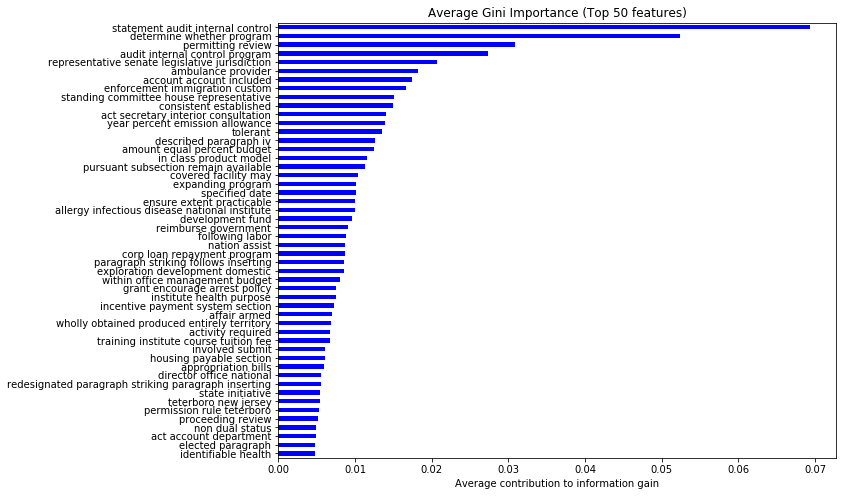

In [18]:
# Plot the feature importance
feat_scores = pd.Series(rf.feature_importances_,
                           index=vocab)

feat_scores = feat_scores.sort_values()[::-1][:50][::-1]
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance (Top 50 features)')
ax.set_xlabel('Average contribution to information gain')

In [ ]:
# my recall scores seem abnormally high... let's iterate through a few different slices to build 
# confidence in our results
recall_scores = []

i = 1
while i < 6:
    print('-------------')
    print('Performing train-test split and vectorizing for iteration {}...'.format(i))
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y)
    
    tfvect = TfidfVectorizer(ngram_range=(1, 5))
    X_train_vec = tfvect.fit_transform(X_train)
    X_test_vec = tfvect.transform(X_test)
    
    print('\tFitting data to Random Forest Classifier...')
    rf = RandomForestClassifier(max_features = 'auto', n_jobs = -1)
    rf.fit(X_train, y_train)

    rf_y_pred = rf.predict(X_test)
    recall_scores.append(recall_score(y_test, rf_y_pred))
    
    i+=1
    

print('Mean recall score after {} iterations: {}'.format(i, np.mean(recall_scores)))